In [1]:
import sys

sys.path.append("..")

In [2]:
from src import config, preprocessing

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tuneta.tune_ta import TuneTA
import talib as ta

In [4]:
df = pd.read_csv("../data/data.csv")
tt = TuneTA(n_jobs=-1, verbose=True)

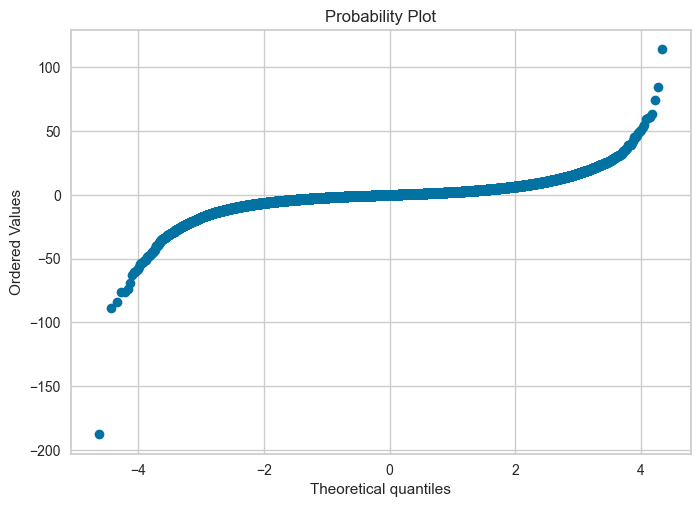

In [52]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df.tsa_residual, dist="norm", plot=plt)
plt.show()

In [16]:
df["slope"] = ta.LINEARREG_SLOPE(df.close, 25)
df["residual"] = df.close - ta.LINEARREG(df.close, 25)

In [38]:
df["intercept"] = ta.LINEARREG_INTERCEPT(df.close, 25)

<AxesSubplot:>

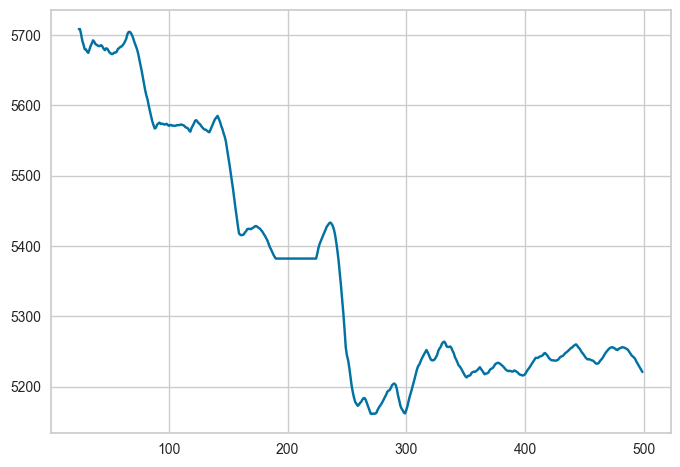

In [39]:
df.intercept[:500].plot()

In [22]:
df["rss"] = np.square(df.residual).rolling(25).sum()

In [24]:
df["t_residual"] = df.close - ta.SMA(df.close, 25)
df["trss"] = np.square(df.t_residual).rolling(25).sum()

<AxesSubplot:>

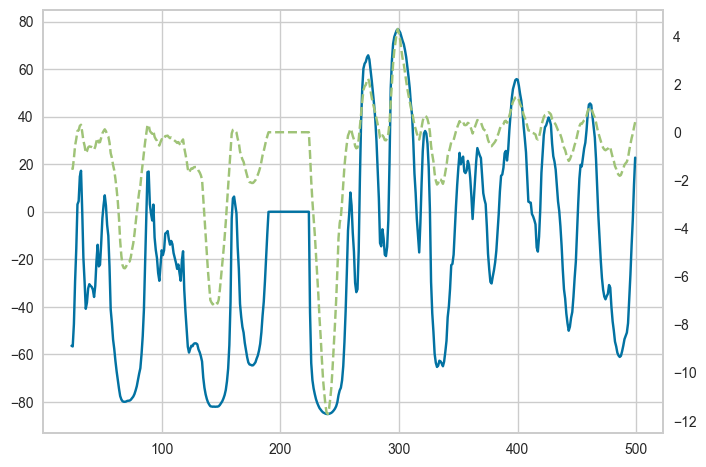

In [44]:
df["linear_angle"] = ta.LINEARREG_ANGLE(df.close, 25)
df.linear_angle[:500].plot()
df.slope[:500].plot(secondary_y=True, style="--")

In [51]:
df["tsa_residual"] = ta.TSF(df.close, 3) - df.close

In [36]:
df["r2"] = np.divide(df.rss, df.trss)

<AxesSubplot:>

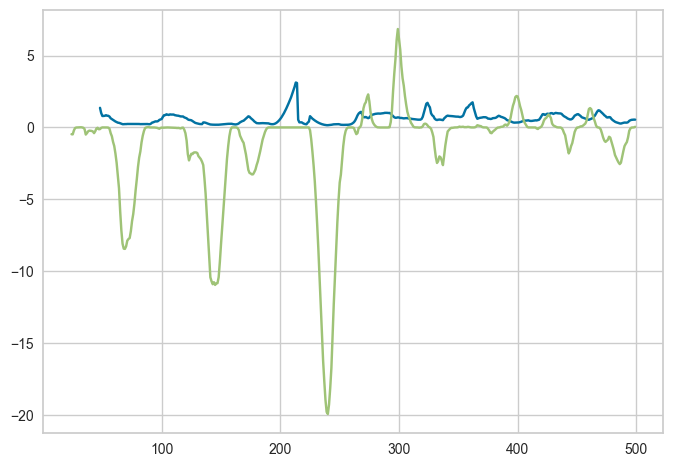

In [40]:
df.r2[:500].plot()
df.skr2[:500].plot()

In [30]:
from sklearn.linear_model import LinearRegression


# 计算强弱得分
def calculate_score(srs, N=25):
    if srs.shape[0] < N:
        return np.nan
    x = np.arange(1, N + 1)
    y = srs.values / srs.values[0]
    lr = LinearRegression().fit(x.reshape(-1, 1), y)
    # 斜率
    slope = lr.coef_[0]
    # 决定系数R2
    r_squared = lr.score(x.reshape(-1, 1), y)
    # 得分
    score = 10000 * slope * r_squared
    return score


# 斜率计算长度
N = 25
# 计算每日涨跌幅和得分
df["skr2"] = df.close.rolling(N).apply(lambda x: calculate_score(x, N))
# 去掉缺失值

In [56]:
df["atr"] = ta.ATR(df.high, df.low, df.close, 25)

In [64]:
df.drop(["open", "high", "low", "close", "volume", "turnover"], axis=1).corr().loc[
    "skr2"
]

open_interest          0.009985
desired_pos_change    -0.441754
desired_pos_rolling    0.579300
slope                  0.961442
reg                    0.010681
residual              -0.200207
rss                   -0.101237
t_residual             0.782136
trss                  -0.150735
r2                     0.000923
skr2                   1.000000
intercept             -0.011505
linear_angle           0.848132
tsa_residual           0.081810
atr                   -0.043809
slope/atr              0.877695
Name: skr2, dtype: float64

In [63]:
df["slope/atr"] = df.slope / df.atr

In [67]:
g = []
for i in range(5, 50):
    df["atr"] = ta.ATR(df.high, df.low, df.close, i)
    df["slope/atr"] = df.slope / df.atr
    gg = (
        df.drop(["open", "high", "low", "close", "volume", "turnover"], axis=1)
        .corr()
        .loc["skr2"]["slope/atr"]
    )
    g.append(gg)

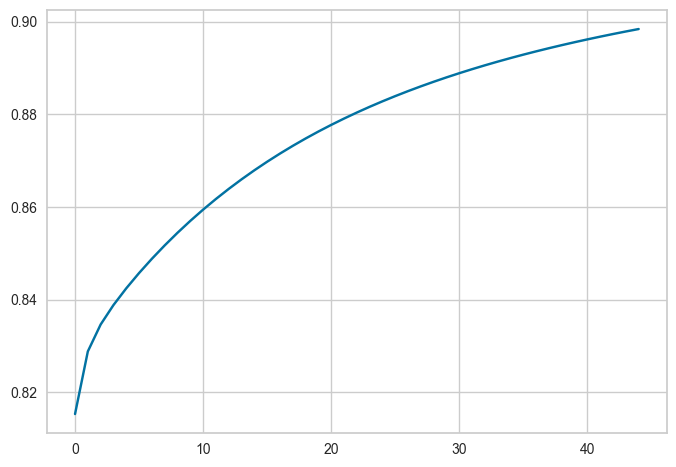

In [68]:
plt.plot(g)

<AxesSubplot:>

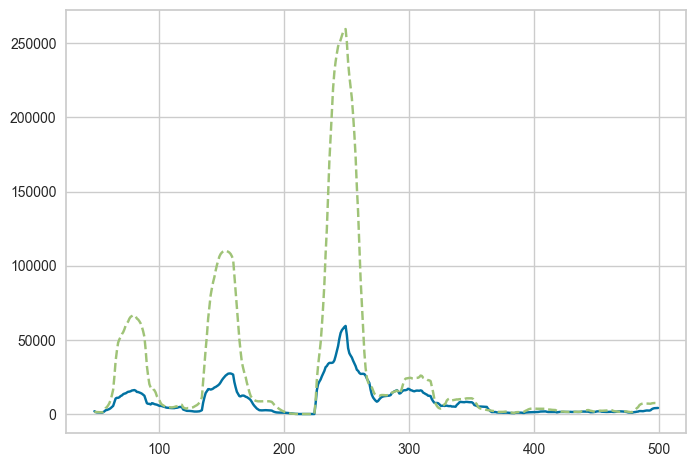

In [27]:
df.rss[:500].plot()
df.trss[:500].plot(style="--")

<AxesSubplot:>

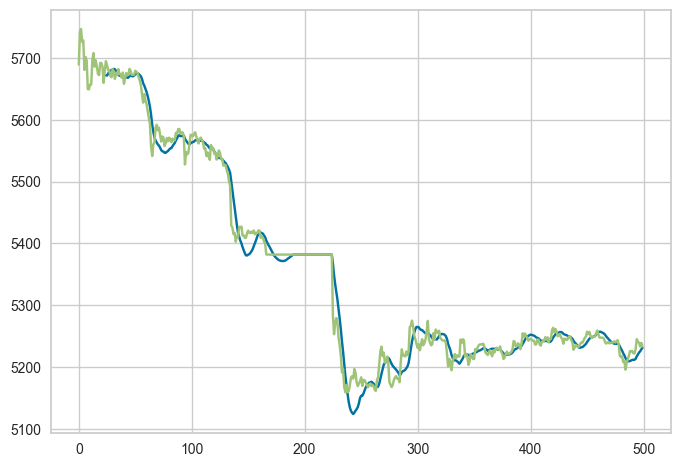

In [15]:
# df.slope[:500].plot()
df.reg[:500].plot()
df.close[:500].plot()

In [5]:
df = preprocessing.prepare_desired_pos(df, 50, 10)

Generating desired position...
Desired position generated


In [6]:
X, y = preprocessing.split_features_target(df)

Splitting features/target


KeyError: "['pos_change_signal'] not found in axis"

In [5]:
df = pd.read_csv("../data/data.csv")
X, y = preprocessing.prep_data(
    df,
    lags=config.LAGS,
    lag=config.FUTURE_PRED,
    multiplier=config.MULTIPLIER_FOR_DESIRED_POS,
)

Generating desired position...


KeyError: ''

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X.reset_index(drop=True), y.reset_index(drop=True), test_size=0.5, shuffle=False
)

In [42]:
y_train["pos_change_signal"].where(
    y_train["pos_change_signal"] == "strong buy"
).isna().sum()

161821

In [11]:
import evalml
from evalml import AutoMLSearch

In [29]:
from evalml.data_checks import DefaultDataChecks

data_checks = DefaultDataChecks("multiclass", "log loss binary")
data_checks.validate(X_train, y_train["desired_pos_change"])

[{'message': 'Target does not have at least two instances per class which is required for multiclass classification',
  'data_check_name': 'InvalidTargetDataCheck',
  'level': 'error',
  'details': {'columns': None,
   'rows': None,
   'least_populated_class_labels': [-338.0,
    -325.0,
    -319.0,
    -286.0,
    -275.0,
    -232.0,
    -224.0,
    -219.0,
    -209.0,
    -207.0,
    -201.0,
    -174.0,
    -163.0,
    -153.0,
    -152.0,
    -146.0,
    -142.0,
    -134.0,
    -131.0,
    -125.0,
    -114.0,
    -112.0,
    -110.0,
    -104.0,
    -102.0,
    -101.0,
    -98.0,
    -88.0,
    -81.0,
    92.0,
    93.0,
    95.0,
    99.0,
    103.0,
    104.0,
    106.0,
    109.0,
    110.0,
    112.0,
    117.0,
    120.0,
    122.0,
    123.0,
    125.0,
    132.0,
    133.0,
    141.0,
    152.0,
    155.0,
    158.0,
    164.0,
    175.0,
    179.0,
    185.0,
    207.0,
    208.0,
    214.0,
    216.0,
    225.0,
    239.0,
    271.0,
    293.0,
    302.0,
    315.0,
    384.0

In [26]:
automl = AutoMLSearch(
    X_train=X_train,
    y_train=y_train["desired_pos_change"],
    problem_type="multiclass",
    holdout_set_size=0,
    objective="auto",
    run_feature_selection=True,
    n_jobs=-1,
    verbose=True,
)

AutoMLSearch will use mean CV score to rank pipelines.
Using default limit of max_batches=2.



In [27]:
automl.search(interactive_plot=False)


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Multiclass. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 2 batches for a total of None pipelines. 
Allowed model families: 

Evaluating Baseline Pipeline: Mode Baseline Multiclass Classification Pipeline


Exception: Missing target values in the training set after data split: {256, 257, 258, 259, 262, 264, 265, 266, 267, 268, 148, 153, 154, 156, 161, 162, 165, 167, 168, 169, 170, 172, 173, 174, 175, 177, 179, 185, 189, 190, 192, 194, 197, 198, 199, 200, 201, 202, 204, 205, 206, 208, 209, 210, 212, 214, 215, 217, 218, 220, 221, 222, 224, 225, 228, 229, 231, 232, 234, 235, 237, 238, 239, 240, 242, 244, 245, 246, 250, 252, 253, 254, 255}. Missing target values in the validation set after data split: {260, 261, 263, 203, 207, 211, 213, 216, 219, 223, 226, 227, 230, 233, 236, 241, 243, 247, 248, 249, 251}.